# Virtual screening of a SARS-CoV-1 bioassay dataset

### Leitura dos bancos de dados e criação dos DataFrames

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
bioassay = pd.read_csv('AID_1706_datatable_all.csv.gz',compression='gzip',skiprows=range(1,5))

In [3]:
total = len(bioassay)

In [4]:
# Remover outliers do ensaio pelo metodo da amplitude interquartil
Q1       = bioassay['Inhibition'].quantile(0.25)
Q3       = bioassay['Inhibition'].quantile(0.75)
IQR      = Q3 - Q1
#bioassay = bioassay[~((bioassay['Inhibition'] < Q1 - 1.5 * IQR)|(bioassay['Inhibition'] > (Q3 + 1.5 * IQR)))]
print(f'{total-len(bioassay)} compostos removidos: {total} -> {len(bioassay)}')

0 compostos removidos: 290893 -> 290893


In [5]:
scores = pd.read_csv('DockFlow_vina.csv.gz',compression='gzip')
scores.sort_values(['id','vina_score'], inplace=True) # make sure that the compounds are ordered
for SF in ['smina']:
    df = pd.read_csv(f'ScoreFlow_{SF}.csv.gz',compression='gzip')
    df.sort_values(['id', SF+'_score'], inplace=True) # make sure that the compounds are ordered
    scores = pd.merge(scores,df,on=['id','pose'])

In [6]:
scores.rename({'id': 'PUBCHEM_SID'}, axis='columns', inplace=True)

In [7]:
scores

,PUBCHEM_SID,pose,vina_score,smina_score
0,842134,1,-6.5,-6.68219
1,842134,2,-6.3,-6.33347
2,842134,3,-6.3,-6.63991
3,842134,4,-6.1,-6.69704
4,842134,5,-6.1,-6.39755
...,...,...,...,...
2723367,51090821,6,-5.9,-6.36111
2723368,51090821,7,-5.7,-5.84297
2723369,51090821,8,-5.4,-5.63190
2723370,51090821,9,-5.3,-5.37468


In [8]:
# Save first pose as top
# top_vina = df_vina.groupby('id').head(1)
# top_vina

In [9]:
# Save first pose as top
# top_smina = df_smina.groupby('id').head(1)
# top_smina

* Criando um DataFrame com todas as funções de pontuação e um outro somente com as melhores poses

In [10]:
# Merge top poses (SMINA results are sorted, so I can consider pose 1)
# top = pd.merge(top_vina, top_smina.drop('pose',axis=1))
# top

In [11]:
# Merge what really matters.
data = pd.merge(bioassay[['PUBCHEM_SID','PUBCHEM_ACTIVITY_OUTCOME','Inhibition']], scores)
data

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,Inhibition,pose,vina_score,smina_score
0,842134,Inactive,0.41,1,-6.5,-6.68219
1,842134,Inactive,0.41,2,-6.3,-6.33347
2,842134,Inactive,0.41,3,-6.3,-6.63991
3,842134,Inactive,0.41,4,-6.1,-6.69704
4,842134,Inactive,0.41,5,-6.1,-6.39755
...,...,...,...,...,...,...
2723367,51090821,Inactive,0.19,6,-5.9,-6.36111
2723368,51090821,Inactive,0.19,7,-5.7,-5.84297
2723369,51090821,Inactive,0.19,8,-5.4,-5.63190
2723370,51090821,Inactive,0.19,9,-5.3,-5.37468


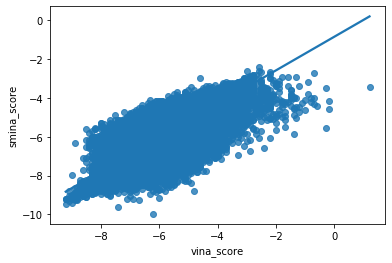

In [11]:
# Is there any correlation between vina and smina scores ?
sns.regplot(data=data,x='vina_score',y='smina_score')

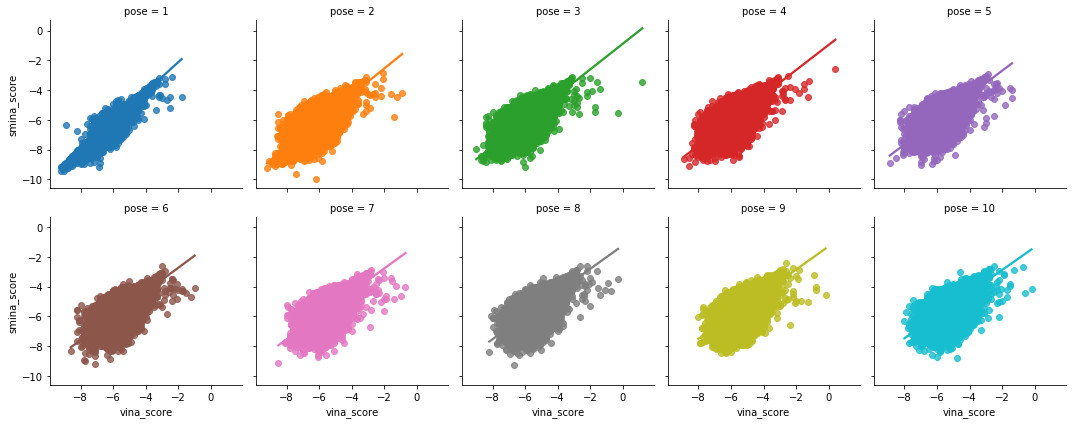

In [12]:
# Is there any correlation between vina and smina scores for all poses ?
g = sns.FacetGrid(data=docking,col='pose',col_wrap=5,hue='pose')
g.map(sns.regplot,'vina_score','smina_score')

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

* Não há relação entre a taxa de inibição e os resultados das funções de pontuação

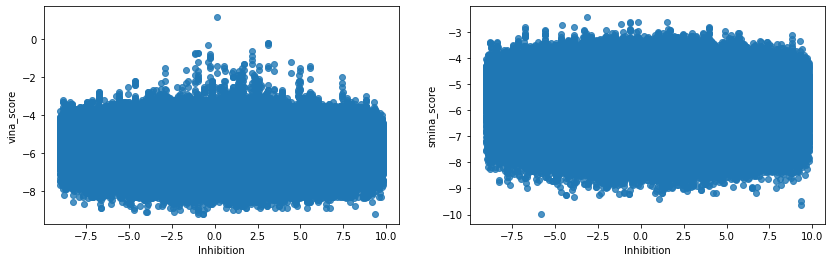

In [15]:
# Is there any correlation between measured inhibition and scores by scoring function ?
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.regplot(data=data, x='Inhibition', y='vina_score',  ax=ax[0])
sns.regplot(data=data, x='Inhibition', y='smina_score', ax=ax[1])

* O gráfico de regressão mostra que não há qualquer relação entre as pontuações do vina e do smina e a taxa de inibição.

Text(0.5, 1, 'Spearman')

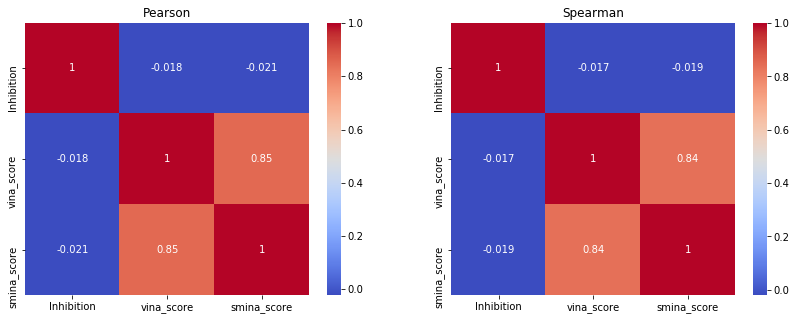

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(data[['Inhibition','vina_score','smina_score']].corr(method='pearson') , annot=True, cmap='coolwarm', ax=ax[0]).set_title('Pearson')
sns.heatmap(data[['Inhibition','vina_score','smina_score']].corr(method='spearman'), annot=True, cmap='coolwarm', ax=ax[1]).set_title('Spearman')

In [13]:
top = scores.query('pose == 1')

### Distribuição das pontuações

* Com o kdeplot, vê-se que as distribuições das variáveis são aproximadamente normais

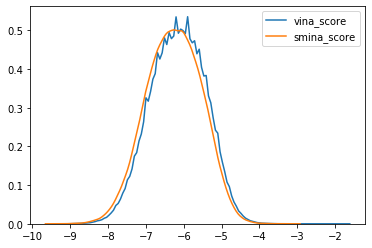

In [16]:
sns.kdeplot(top['vina_score'])
sns.kdeplot(top['smina_score'])

* Correlações entre os scores para a top pose do vina

Text(0.5, 1, 'Spearman')

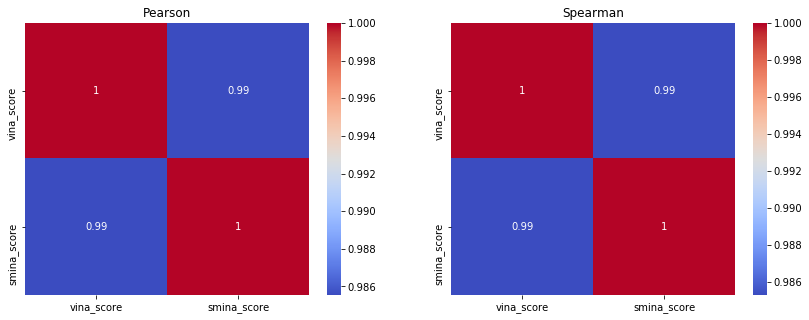

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(top[['vina_score','smina_score']].corr(method='pearson') , annot=True, cmap='coolwarm', ax=ax[0]).set_title('Pearson')
sns.heatmap(top[['vina_score','smina_score']].corr(method='spearman'), annot=True, cmap='coolwarm', ax=ax[1]).set_title('Spearman')

* Coeficiente de determinação (R²)

In [14]:
from sklearn.metrics import r2_score

In [15]:
r2_score(top['vina_score'], top['smina_score'])

0.9491739476795964

### Classificação em compostos ativos e em compostos inativos

* A tabela de descrição para cada função de pontuação mostra que não há tendências divergentes dos valores das pontuações quando se leva em conta a atividade determinada experimentalmente. Ou seja, não é possível classificar uma pose entre ativa e inativa somente com base na pontuação de saída do vina e do smina.

In [18]:
data.groupby('PUBCHEM_ACTIVITY_OUTCOME')[['vina_score', 'smina_score']].describe()

vina_score                                          \
                              count      mean       std  min  25%  50%  75%   
PUBCHEM_ACTIVITY_OUTCOME                                                      
Active                       3850.0 -5.588571  0.717516 -8.2 -6.1 -5.5 -5.1   
Inactive                  2719522.0 -5.493057  0.716091 -9.2 -6.0 -5.4 -5.0   

                              smina_score                               \
                          max       count      mean       std      min   
PUBCHEM_ACTIVITY_OUTCOME                                                 
Active                   -3.4      3850.0 -5.719427  0.730140 -8.24237   
Inactive                  1.2   2719522.0 -5.607914  0.726671 -9.96106   

                                                                
                               25%      50%       75%      max  
PUBCHEM_ACTIVITY_OUTCOME                                        
Active                   -6.190415 -5.65083 -5.201968 -3.57797  
Inactive                 -6.080300 -5.54297 -5.085102 -2.41681

* É possível visualizar a uniformidade entre esses dados com os histogramas.

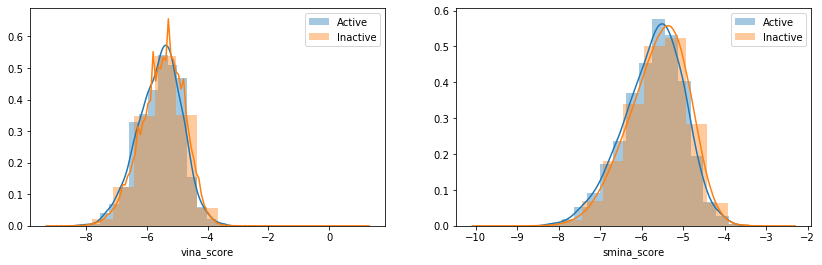

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.distplot(data[data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']['vina_score']   , bins=15, ax=ax[0])
sns.distplot(data[data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive']['vina_score'] , bins=15, ax=ax[0])
sns.distplot(data[data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']['smina_score']  , bins=15, ax=ax[1])
sns.distplot(data[data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive']['smina_score'], bins=15, ax=ax[1])
[axis.legend(['Active', 'Inactive']) for axis in ax]

In [20]:
from sklearn.metrics import roc_curve, auc

In [21]:
data

,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,Inhibition,pose,vina_score,smina_score
0,842134,Inactive,0.41,1,-6.5,-6.68219
1,842134,Inactive,0.41,2,-6.3,-6.33347
2,842134,Inactive,0.41,3,-6.3,-6.63991
3,842134,Inactive,0.41,4,-6.1,-6.69704
4,842134,Inactive,0.41,5,-6.1,-6.39755
...,...,...,...,...,...,...
2723367,51090821,Inactive,0.19,6,-5.9,-6.36111
2723368,51090821,Inactive,0.19,7,-5.7,-5.84297
2723369,51090821,Inactive,0.19,8,-5.4,-5.63190
2723370,51090821,Inactive,0.19,9,-5.3,-5.37468


[Scoring Function]: [AUC]
vina: 0.453675
smina: 0.453707


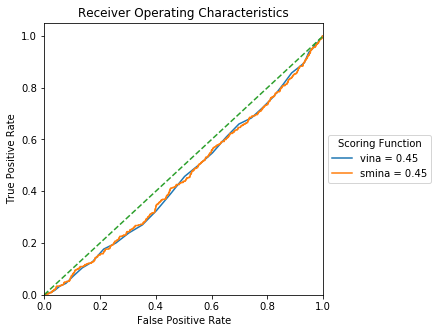

In [22]:
print('[Scoring Function]: [AUC]')
fig, ax = plt.subplots(figsize=(5,5))
for f in ['vina','smina']:
    # 1st top pose according to each scoring function
    fpr, tpr, _ = roc_curve(data.query('pose == 1')['PUBCHEM_ACTIVITY_OUTCOME'].to_numpy(), 
                            data.query('pose == 1')[f+'_score'].to_numpy(), pos_label='Active')
    roc_auc = auc(fpr, tpr)
    print(f'{f}: {roc_auc:>.6f}')
    ax.plot(fpr, tpr, label=f'{f} = {roc_auc:>.2f}')

# Plot a line
ax.plot([0,1], [0,1], linestyle='--')

# Some legends
ax.set(xlim=[0.0,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', 
       title='Receiver Operating Characteristics')
plt.legend(title='Scoring Function', loc='center left', bbox_to_anchor=(1.0, 0.5))